The goal of this notebook is to explore the "power model", one limit of the IDE model.

The result of the power model derivation is
$$ \dot{b}(t) = -F(t) \cdot \tilde{v}(t) \, b(t) / E_h $$
where $b$ is the bound state amplitude, $F(t)$ is the electric force on the electron from the laser field, $\tilde{v}$ is something with units of velocity that is the result of integrating the vector potential against the kernel, and $E_h$ is the Hartree energy ($27.2 \, \mathrm{eV}$). This provides an immediate physical interpretation: the ionization rate is determined by comparing the amount of power being transferred to the electron to the binding potential.

In [1]:
import logging
import os
import functools
import datetime

import numpy as np
import scipy.optimize as optim

import simulacra as si
import simulacra.units as u

import ionization as ion

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'PowerModel')
SIM_LIB = os.path.join(OUT_DIR, 'SIMLIB')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    fig_dpi_scale = 1.5,
)

CHECKPOINT_KWARGS = dict(
    checkpoints = True,
    checkpoint_dir = SIM_LIB,
    checkpoint_every = datetime.timedelta(minutes = 1),
)

%matplotlib inline

The most obvious question to ask is: what does $F(t) \cdot \tilde{v}(t)$ look like for some pulses? We'll start by using $\tilde{v} \rightarrow v(t)$, the actual classical velocity.

In [12]:
def get_force(electric_potential, times, charge = u.electron_charge):
    return charge * electric_potential.get_electric_field_amplitude(times)

def get_classical_velocity(electric_potential, times, charge = u.electron_charge, mass = u.electron_mass_reduced):
    return -charge * pulse.get_vector_potential_amplitude_numeric_cumulative(times) / mass

def plot_classical_power(electric_potential, times, time_bound):
    force = get_force(electric_potential, times)
    velocity = get_classical_velocity(electric_potential, times)
    
    si.vis.xy_plot(
        'classical_power',
        times,
        force / u.atomic_force,
        velocity / u.atomic_velocity,
        force * velocity / (u.hartree / u.atomic_time),
        line_labels = [
            r'$ F(t) $',
            r'$ v(t) $',
            r'$ P(t) $',
        ],
        x_unit = 'asec',
        x_label = r'$ t $',
        **PLOT_KWARGS
    )

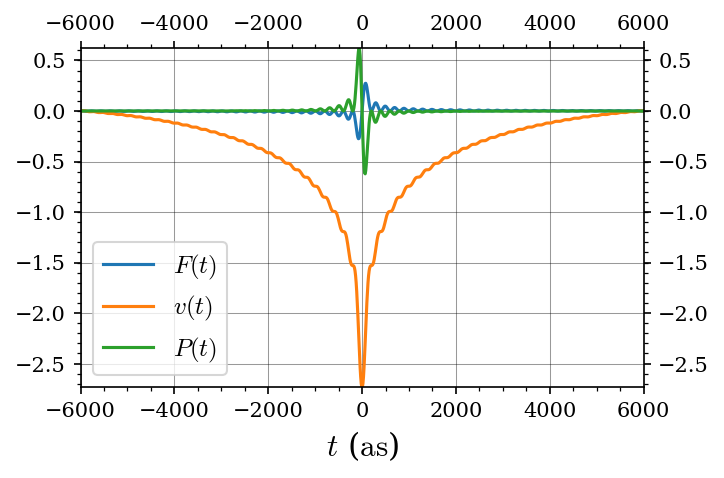

In [13]:
pulse = ion.potentials.SincPulse(pulse_width = 200 * u.asec, fluence = 1 * u.Jcm2, phase = u.pi / 2)
times = np.linspace(-30 * pulse.pulse_width, 30 * pulse.pulse_width, 1_000)
plot_classical_power(pulse, times, 5 * pulse.pulse_width)

Unfortunately, we're running into an obvious problem with the purely-classical version of the model: a classical electron can't absorb energy just from a laser field with no other potentials present. The net delivered power (i.e., the change in kinetic energy) is always zero. We need to try to include at least some of the effect of the kernel (the thing that makes this interaction non-classical) to see our expected behavior. 